In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import pickle
import cartopy.crs as ccrs
import geopandas as gpd
from palettable.colorbrewer.sequential import PuBu_9_r
from palettable.colorbrewer.diverging import RdBu_10

import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg
from osgeo import osr

# Load atmospheric data

In [2]:
# T2M
X = np.load("inference.npy")
t2m = X[:, 0]
print(t2m.shape)

# Ratio
ratio = np.load("ratio.npy")
print(ratio.shape)

(22977621,)
(4401, 5221)


# Create xarray dataarray

In [3]:
# Load datasets for shape and masking
src_path = "ATL15_AA_0311_01km_001_01.nc"
ds = xr.open_dataset(src_path, group='delta_h')

M2_RF = xr.open_dataset("RF_Snow_Red_prelim.nc")['IS2_opt']
M2_RF = M2_RF / M2_RF

indf = 9
ind0 = 5
dh = ds['delta_h'][indf,:,:] - ds['delta_h'][ind0,:,:]
grounded_mask = np.load("grounded-mask/grounded_mask.npy")
grounded_mask = xr.DataArray(data=np.flipud(grounded_mask), dims=["y", "x"], coords=[ds['y'],ds['x']])
dh = dh * grounded_mask * M2_RF

# Target dataarray
t2m = xr.DataArray(data=np.reshape(t2m, dh.shape), dims=["y", "x"], coords=[dh['y'],dh['x']])
t2m = t2m * grounded_mask

ratio = xr.DataArray(data=np.reshape(ratio, dh.shape), dims=["y", "x"], coords=[dh['y'],dh['x']])
ratio = ratio * grounded_mask

# Make pretty map

In [4]:
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
df = df.to_crs(epsg='3031')
n_poly = len(df['geometry'])

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


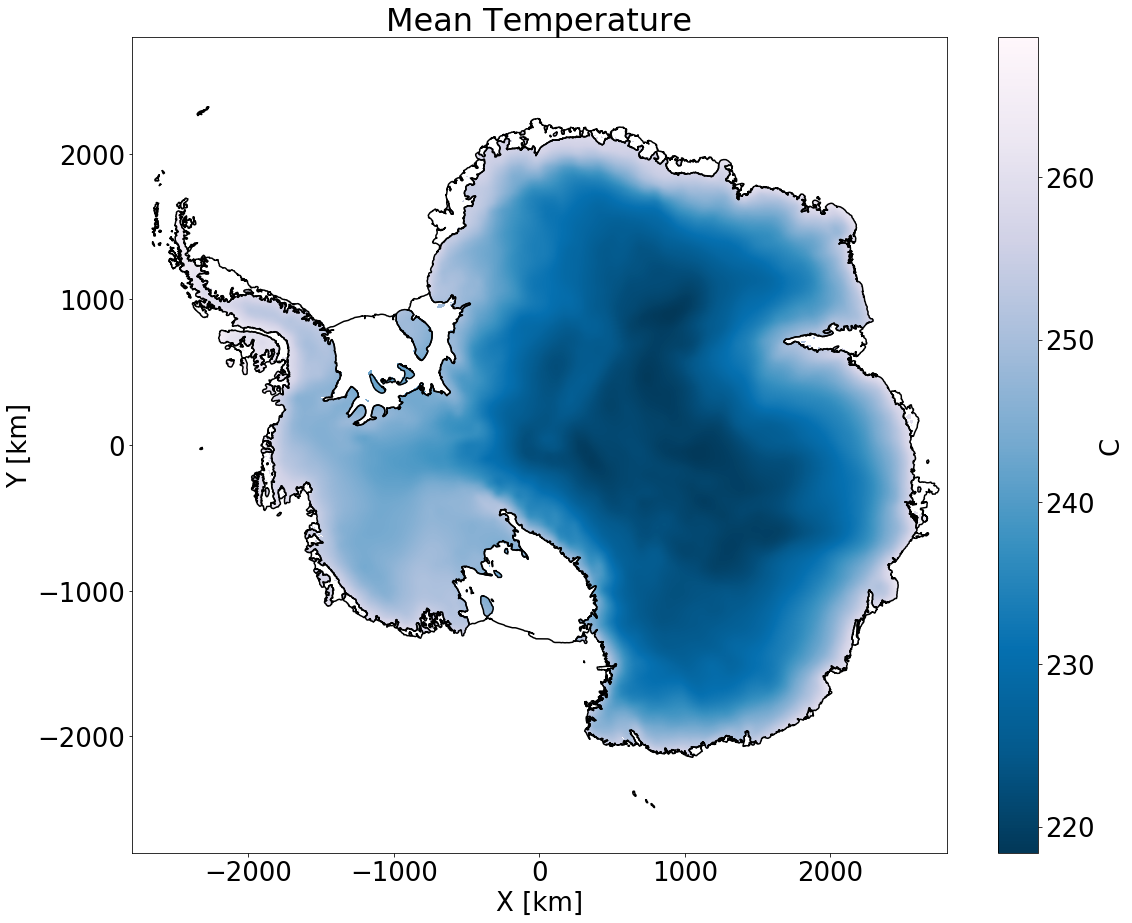

In [5]:
plt.figure(figsize=(18.25, 15))
axis_lim = 2800

for j in range(0, n_poly):
    x_poly, y_poly = df['geometry'][j].exterior.coords.xy
    x_poly = np.array(x_poly)
    y_poly = np.array(y_poly)
    x_poly = np.append(x_poly/1000, x_poly[0]/1000)
    y_poly = np.append(y_poly/1000, y_poly[0]/1000)
    plt.plot(x_poly, y_poly, 'k-')

plt.pcolormesh(t2m['x']/1000, t2m['y']/1000, \
           t2m, cmap=PuBu_9_r.mpl_colormap, rasterized=True)
cb = plt.colorbar()
cb.set_label("C", fontsize=26)
cb.ax.tick_params(labelsize=26) 
plt.xlabel("X [km]", fontsize=26)
plt.ylabel("Y [km]", fontsize=26)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.title("Mean Temperature", fontsize=32)
plt.xlim([-axis_lim, axis_lim])
plt.ylim([-axis_lim, axis_lim])

plt.savefig("figures/schematic_t2m.pdf", dpi=100)

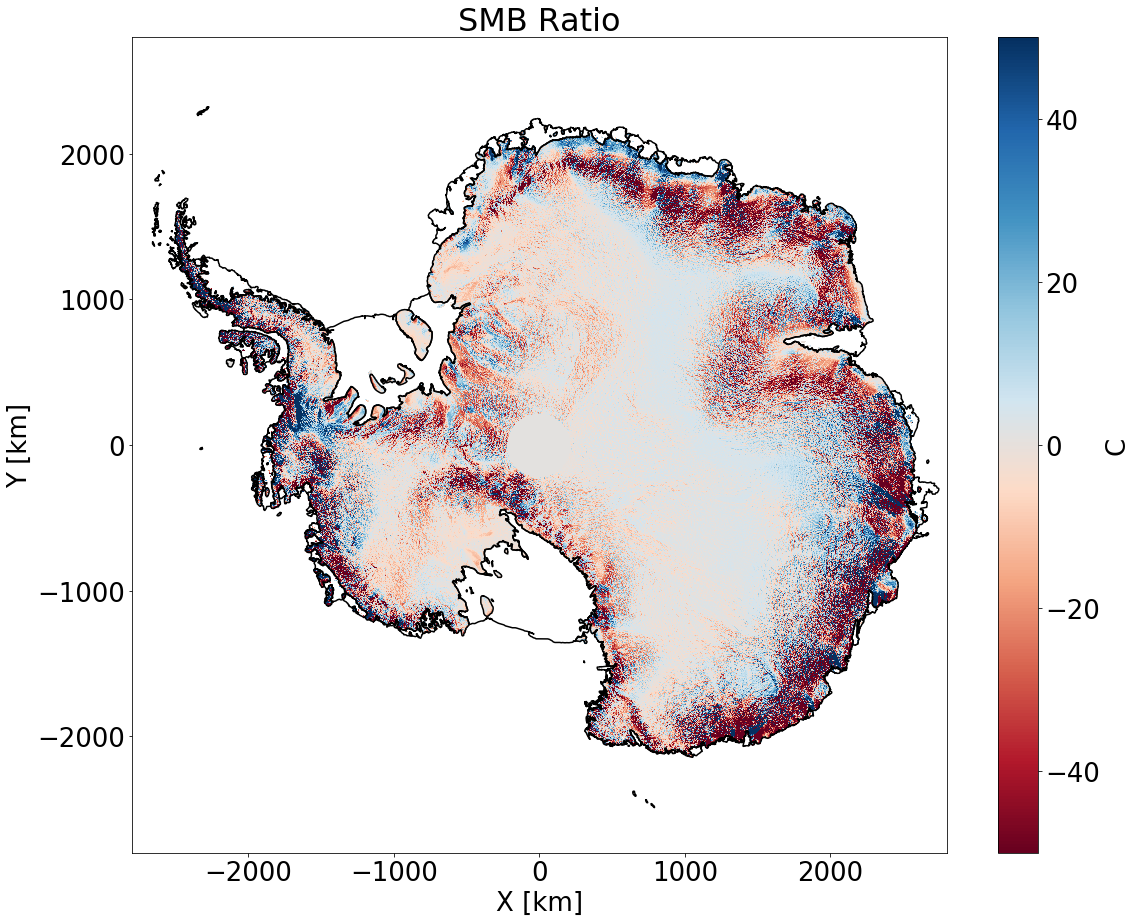

In [6]:
plt.figure(figsize=(18.25, 15))
axis_lim = 2800

for j in range(0, n_poly):
    x_poly, y_poly = df['geometry'][j].exterior.coords.xy
    x_poly = np.array(x_poly)
    y_poly = np.array(y_poly)
    x_poly = np.append(x_poly/1000, x_poly[0]/1000)
    y_poly = np.append(y_poly/1000, y_poly[0]/1000)
    plt.plot(x_poly, y_poly, 'k-')

plt.pcolormesh(t2m['x']/1000, t2m['y']/1000, \
           ratio, cmap=RdBu_10.mpl_colormap, rasterized=True, vmin=-50, vmax=50)
cb = plt.colorbar()
cb.set_label("C", fontsize=26)
cb.ax.tick_params(labelsize=26) 
plt.xlabel("X [km]", fontsize=26)
plt.ylabel("Y [km]", fontsize=26)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.title("SMB Ratio", fontsize=32)
plt.xlim([-axis_lim, axis_lim])
plt.ylim([-axis_lim, axis_lim])

plt.savefig("figures/schematic_ratio.pdf", dpi=100)